# ltu-ili jupyter interface
This is a tutorial for using the ltu-ili inference framework in a jupyter notebook. 

This notebook assumes you have installed the ltu-ili package from the installation instructions in [INSTALL.md](../INSTALL.md).

In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import sbi

from ili.dataloaders import NumpyLoader
from ili.inference.runner_sbi import SBIRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


## Toy SNPE
This example attempts to infer 3 unknown parameters from a 20-dimensional 1D data vector using amortized posterior inference. We train the models from a simple synthetic catalog. This tutorial mirrors the same configuration as in [examples/toy_sbi.py](../examples/toy_sbi.py), but demonstrates how one would interact with the inference pipeline in a jupyter notebook.

In [26]:
# create synthetic catalog
def simulator(params):
    # create toy simulations
    x = np.linspace(0, 10, 20)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += 1*np.random.randn(len(x))
    return y

seed_sim = 1962
np.random.seed(seed_sim)
theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

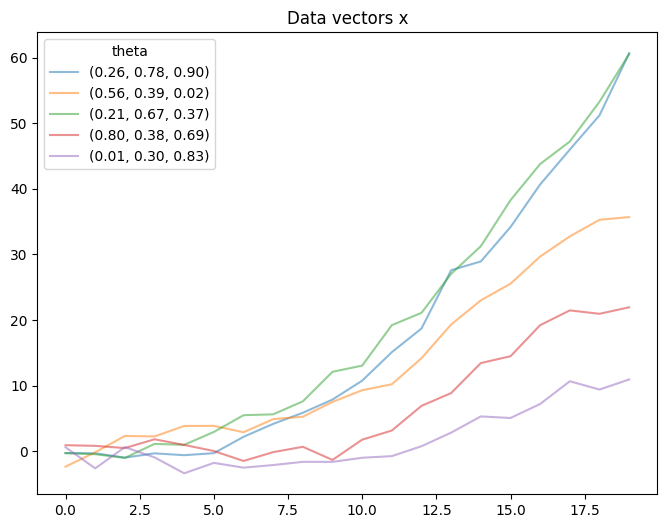

In [27]:
# plot some examples of the data
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5):
    ind = np.random.randint(len(theta))
    ax.plot(x[ind], alpha=0.5, label=f'(%.2f, %.2f, %.2f)' % tuple(theta[ind]))
ax.legend(title='theta')
ax.set_title('Data vectors x')
plt.show()

The SBIRunner object will handle all of the data normalization and model training for us. We just need to provide it with:
- our parameter prior
- our inference type (SNPE/SNLE/SNRE)
- our desired neural network architecture
- our training hyperparameters

On the backend, it does a validation split among the provided training data, trains the neural networks with an Adam optimizer, and enforces an early stopping criterion to prevent overfitting. All the parameters of these processes can be independently configured.

In [28]:
# define a prior
prior = sbi.utils.BoxUniform(low=(0,0,0), high=(1,1,1), device=device)

# define an inference class (here, we are doing amortized posterior inference)
inference_class = sbi.inference.SNPE

# Optional signatures (not used, for illustration here)
signatures = ["maf_test", "mdn_test"]

# instantiate your neural networks to be used as an ensemble
nets = [
    sbi.utils.posterior_nn(model='maf', hidden_features=50, num_transforms=5),
    sbi.utils.posterior_nn(model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-3
}

# initialize the trainer
runner = SBIRunner(
    prior=prior,
    inference_class=inference_class,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    output_path=None,
    signatures = signatures# no output path, so nothing will be saved to file
)

In [33]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: SNPE_C
INFO:root:Training model 1 out of 2 ensemble models


 Neural network successfully converged after 287 epochs.

INFO:root:Training model 2 out of 2 ensemble models


 Neural network successfully converged after 329 epochs.

INFO:root:It took 36.65248513221741 seconds to train all models.


Here, the output of the runner is a posterior model and a log of training statistics. The posterior model is a [NeuralPosteriorEnsemble](https://github.com/mackelab/sbi/blob/6c4fa7a6fd254d48d0c18640c832f2d80ab2257a/sbi/utils/posterior_ensemble.py#L19) model and automatically combines samples and probability densities from its component networks.

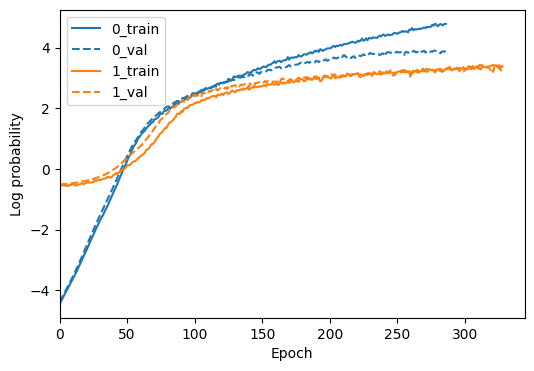

In [34]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [35]:
# Now, SBIRunner returns a custom class instance to be able to pass signature strings
# This class has simply for attributes a NeuralPosteriorEstimate and a string list 
print(posterior_ensemble.signatures)

# choose a random input
seed_in = 49
np.random.seed(seed_in)
ind = np.random.randint(len(theta))

# generate samples from the posterior using accept/reject sampling
seed_samp = 32
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), torch.Tensor(x[ind]).to(device))

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, torch.Tensor(x[ind]).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

['maf_test', 'mdn_test']


Drawing 541 posterior samples:   0%|          | 0/541 [00:00<?, ?it/s]

Drawing 459 posterior samples:   0%|          | 0/459 [00:00<?, ?it/s]

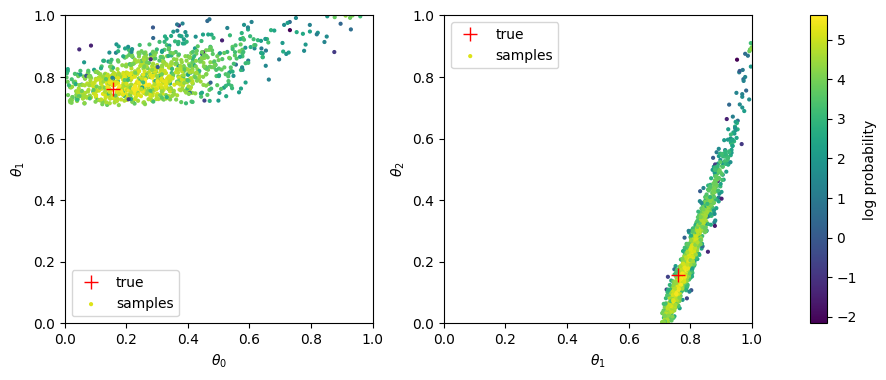

In [36]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[2])

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

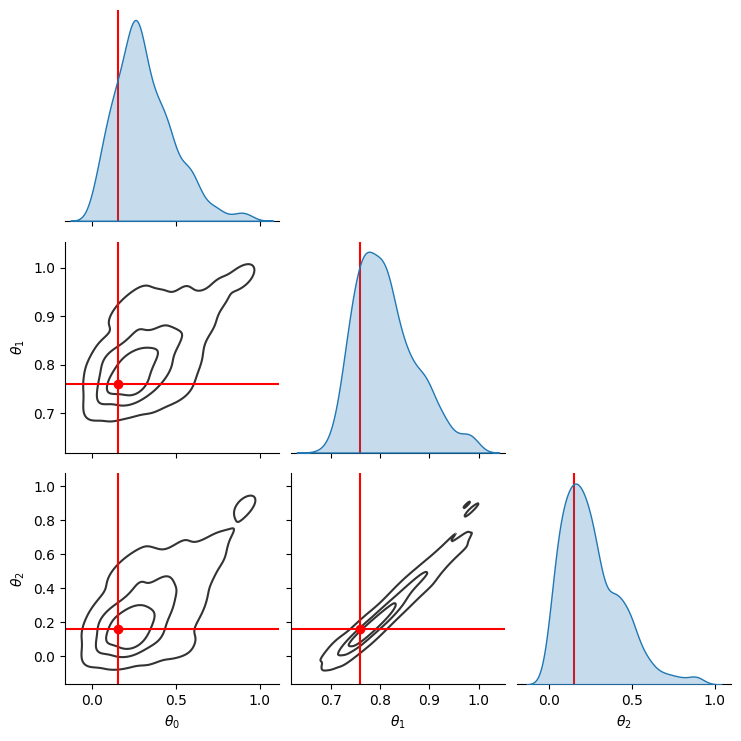

In [37]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='direct', labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_obs=theta[ind],
    x=x, theta=theta
)

### Using the ensemble of trained posteriors models
By default, running a SampleBasedMEtric with posterior from above will compute the metrics using the ensemble model. That is to say the ensemble is considered one model, with the weights of each posterior in the ensemble being the val_log_prob.

100%|██████████| 200/200 [00:03<00:00, 64.39it/s]


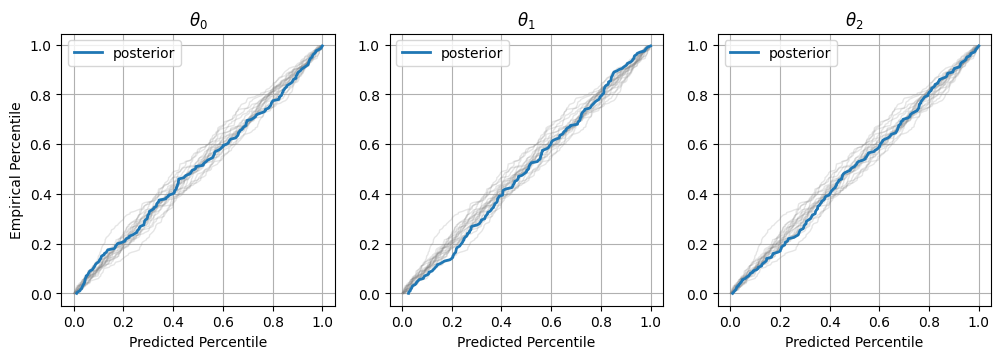

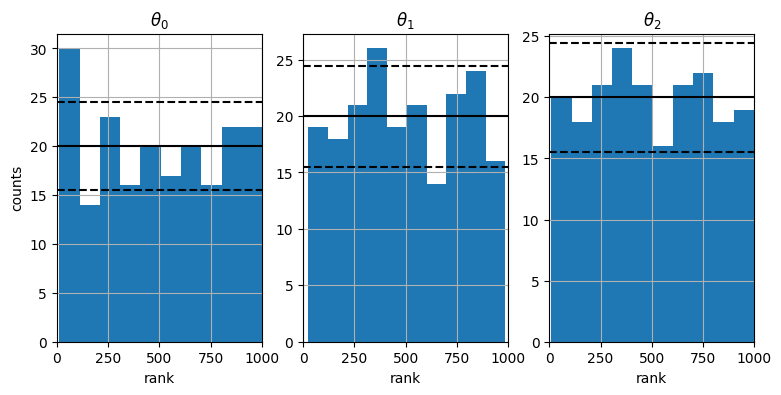

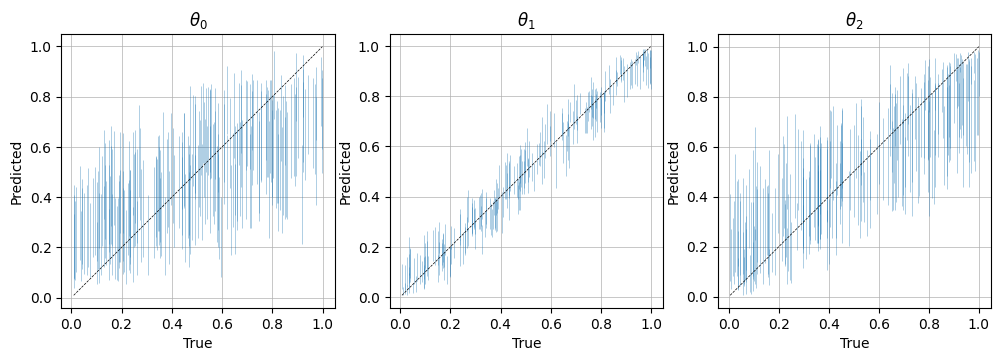

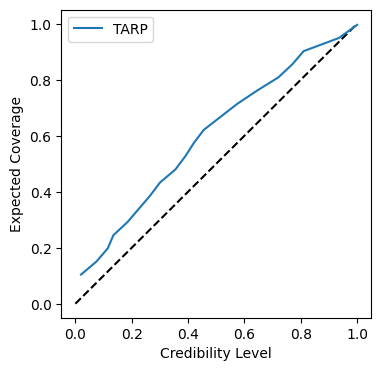

In [38]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='direct', labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"])

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x_obs = x[ind], theta_obs=theta[ind],
    x=x, theta=theta
)

In the ensemble model, it looks like our posteriors are well-calibrated when evaluated on marginal distributions, but slightly negatively biased in the multivariate TARP coverage.

### Evaluating each trained posterior in the ensemble
Below, we compute separately each SampleBasedMetric for every posterior in the ensemble.

100%|██████████| 200/200 [00:02<00:00, 78.06it/s]


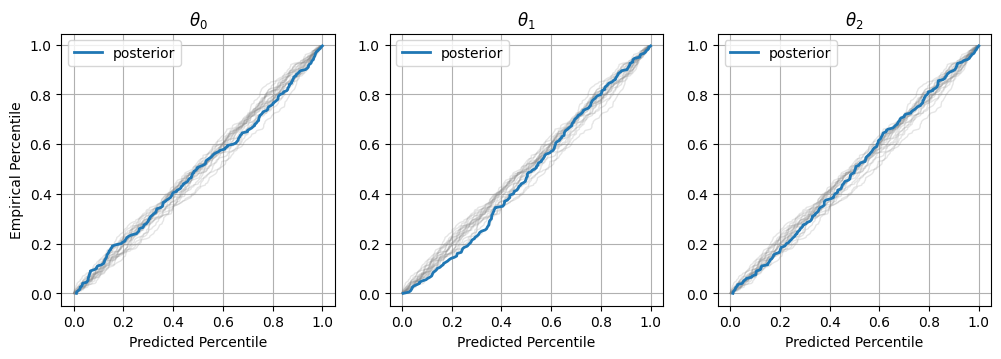

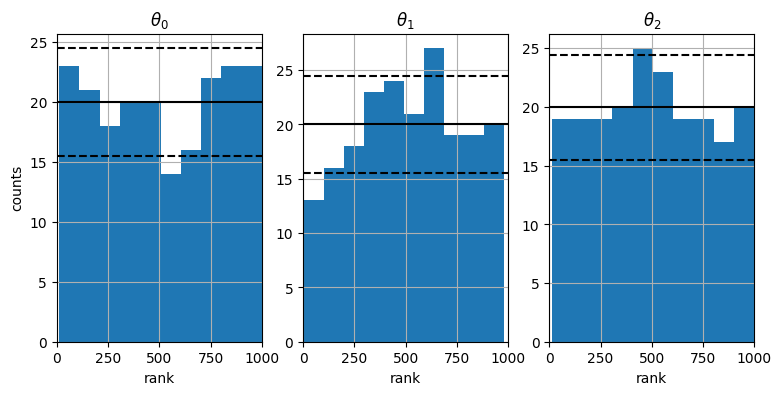

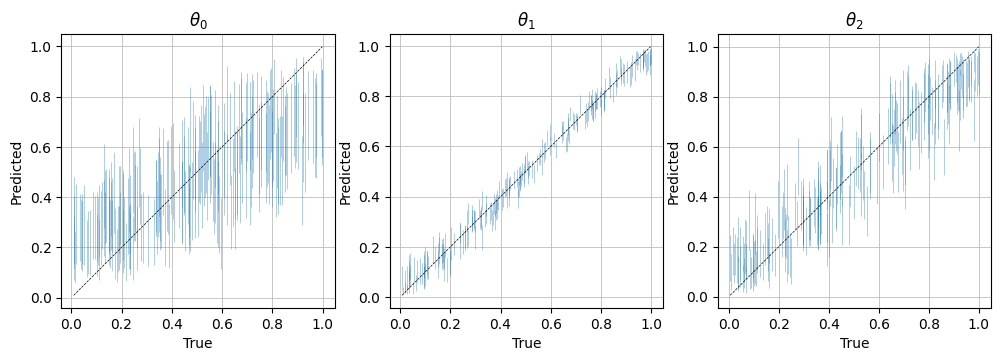

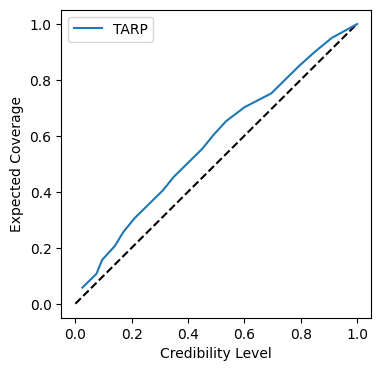

In [39]:
# Drawing samples for each posterior in the ensemble
# First the MAF posterior
metric = PosteriorCoverage(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='direct', labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"])

fig = metric(
    posterior=posterior_ensemble.posteriors[0],
    x_obs = x[ind], theta_obs=theta[ind],
    x=x, theta=theta
)

100%|██████████| 200/200 [00:00<00:00, 333.11it/s]


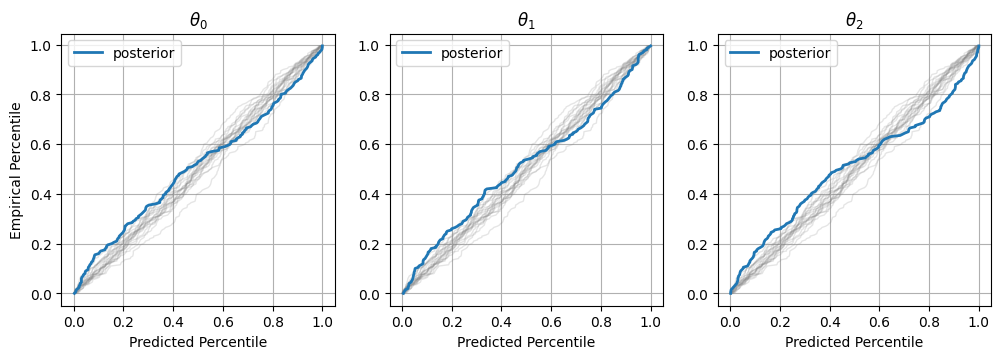

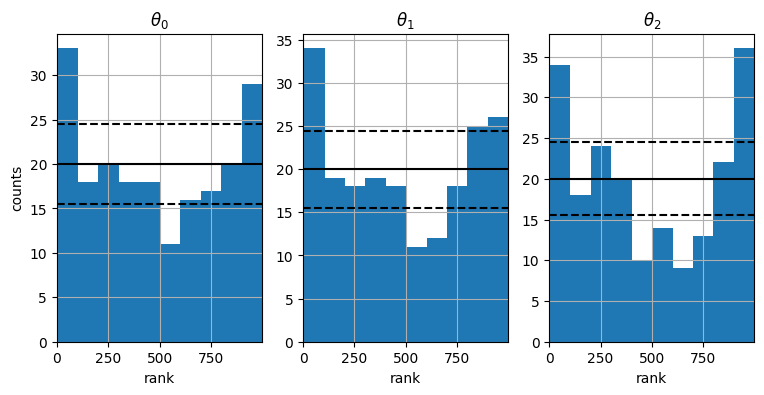

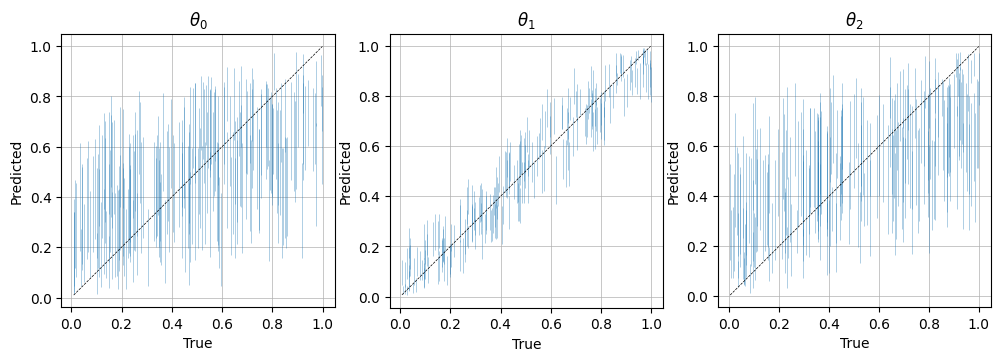

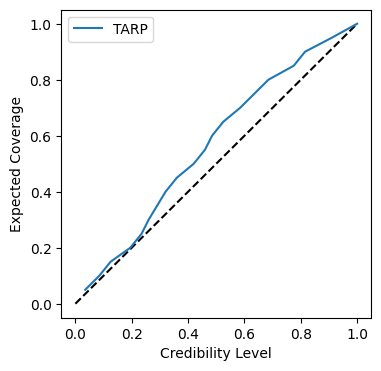

In [40]:
# Then for the MDN
fig = metric(
    posterior=posterior_ensemble.posteriors[1], # NeuralPosteriorEnsemble instance from sbi package
    x_obs = x[ind], theta_obs=theta[ind],
    x=x, theta=theta
)

From these results, we see that we are largely consistent and calibrated in the univariate coverage, with some slight negative bias shown in the multivariate coverage. It looks like the MAF model has slightly better constraints than the MDN model, while retaining the same calibration.

## Toy SNLE
This example uses the same dataset as the previous SNPE example, but uses a likelihood estimation model instead of an amortized posterior estimation.

In [2]:
# create the same synthetic catalog as the previous example
def simulator(params):
    # create toy simulations
    x = np.linspace(0, 10, 20)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += 1*np.random.randn(len(x))
    return y

seed_sim = 1996
np.random.seed(seed_sim)
theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

In [3]:
# define a prior
prior = sbi.utils.BoxUniform(low=(0,0,0), high=(1,1,1), device=device)

# define an inference class (here, we are doing amortized likelihood inference)
inference_class = sbi.inference.SNLE

# instantiate your neural networks to be used as an ensemble
nets = [
    sbi.utils.likelihood_nn(model='maf', hidden_features=50, num_transforms=5),
    sbi.utils.likelihood_nn(model='made', hidden_features=50, num_transforms=5)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = SBIRunner(
    prior=prior,
    inference_class=inference_class,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    output_path=None  # no output path, so nothing will be saved to file
)

In [4]:
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: SNLE_A
INFO:root:Training model 1 out of 2 ensemble models


 Training neural network. Epochs trained: 503

INFO:root:Training model 2 out of 2 ensemble models


 Training neural network. Epochs trained: 525511 epochs.

INFO:root:It took 16.270355939865112 seconds to train all models.


 Neural network successfully converged after 530 epochs.

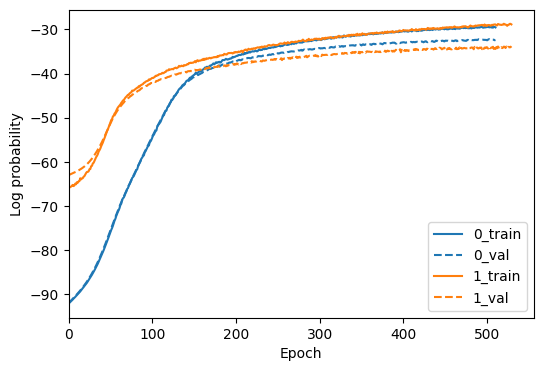

In [5]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [6]:
# choose a random input
seed_ind = 24
np.random.seed(seed_ind)
ind = np.random.randint(len(theta))

# generate samples from the posterior using MCMC
samples = posterior_ensemble.sample(
    (1000,), x[ind], 
    method='slice_np_vectorized', num_chains=6
).detach().cpu().numpy()

# calculate the potential (prop. to log_prob) for each sample
log_prob = posterior_ensemble.log_prob(
    samples, 
    x[ind]
).detach().cpu().numpy()

Running vectorized MCMC with 6 chains:   0%|          | 0/5652 [00:00<?, ?it/s]

Running vectorized MCMC with 6 chains:   0%|          | 0/5550 [00:00<?, ?it/s]

Note: Amortized liklihood estimators do not directly estimate the posterior, but instead build a model for the relative likelihood. This can be combined with a prior to estimate the potential function, which is proportional to the log_probability up to a normalizing constant. Hence, we use MCMC sampling for SNLE models to probe the posterior distribution.

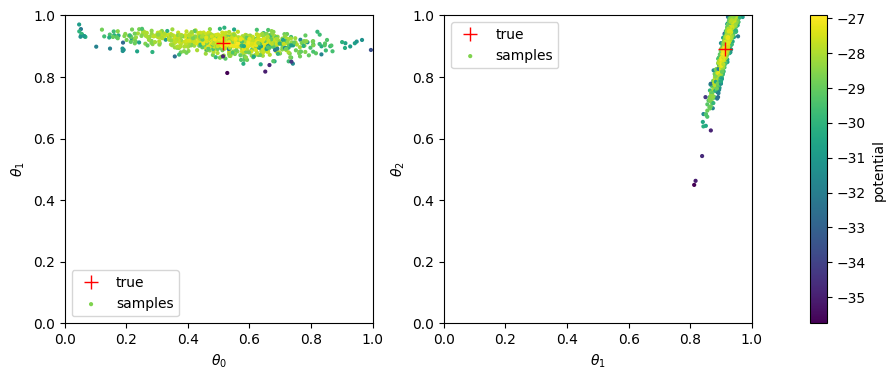

In [7]:
# plot the posterior samples and the true value
f, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='potential', use_gridspec=True, cax=axs[2])

### (We will sample only from the ensemble posterior in this section)

100%|██████████| 200/200 [12:18<00:00,  3.69s/it]


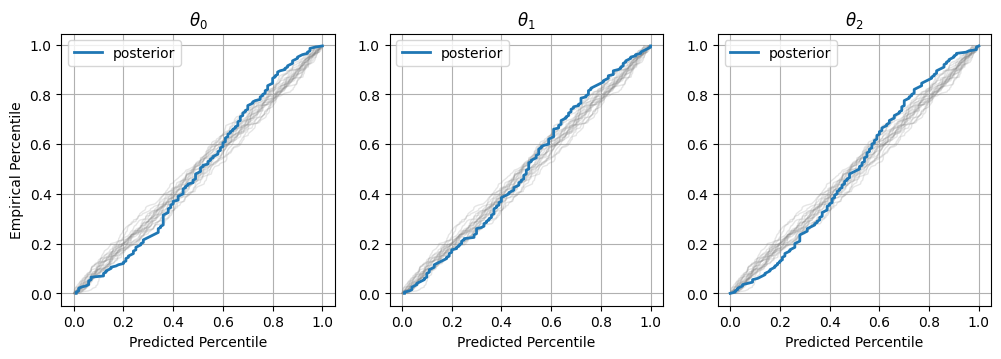

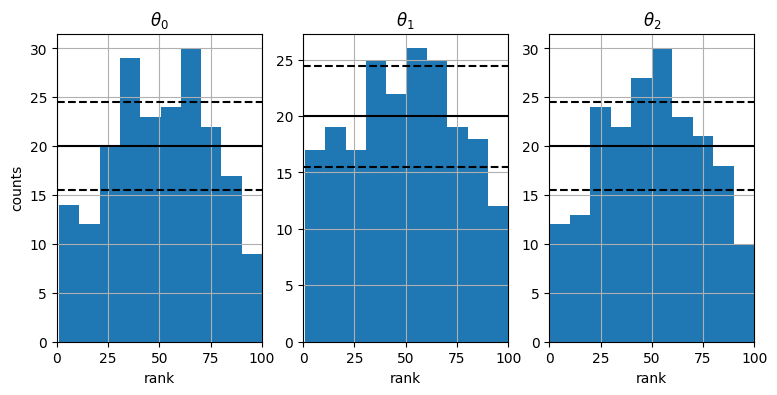

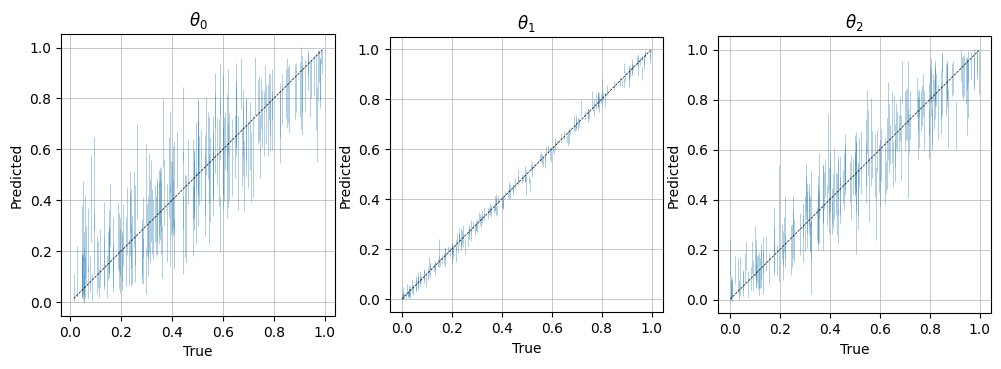

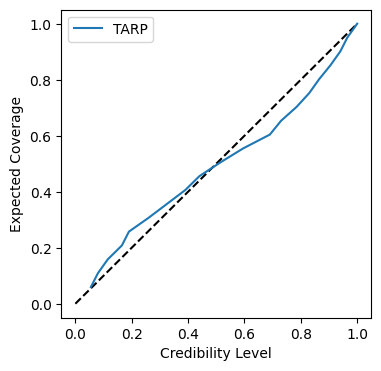

In [9]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PosteriorCoverage(
    backend='sbi', output_path=None, num_samples=100, 
    sample_method='slice_np_vectorized',
    sample_params={'num_chains': 6, 'burn_in':20, 'thin': 3},
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"]
)

# Drawing samples from the ensemble posterior

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x_obs = x[ind], theta_obs=theta[ind],
    x=x, theta=theta
)

Looks like we're well-calibrated in both univariate and multivariate tests, with much tighter constraints on $\theta_1$ than the SNPE!

## CAMELS CMD 2D SNPE
The real utility of ltu-ili is in its flexibility for applicaiton to a wide variety of real datasets. Through the use of customizable embedding networks, this framework can be extended to handle e.g. image, point cloud, or time-series inputs.

In this example, our inputs are 2D slices of the gas temperature of the simulations in the [CAMELS Multifield Dataset](https://camels-multifield-dataset.readthedocs.io/en/latest/) and our target parameters are 6 cosmological and astrophysical parameters (Omega_m, sigma_8, A_SN1, A_AGN1, A_SN2, A_AGN2) that were used to run the simulation. This inference pipeline follows the procedure of the [CAMELS 2D Inference colab example](https://colab.research.google.com/drive/1-BmkA8JSc36O8g9pj7FenD1YSLKqjQR3?usp=sharing).

In [28]:
# Download CAMELS 2D maps and latin hypercube parameters (~3.2 GB)
import os
os.makedirs('./toy', exist_ok=True)
!curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_T_IllustrisTNG_LH_z=0.00.npy -o ./toy/Maps_T_IllustrisTNG_LH_z=0.00.npy
!curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_LH_IllustrisTNG.txt -o ./toy/params_LH_IllustrisTNG.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0 3750M    0 6628k    0     0   487k      0  2:11:23  0:00:13  2:11:10  634k^C
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48000  100 48000    0     0  47111      0  0:00:01  0:00:01 --:--:-- 47151


In [41]:
# load data
x = np.log10(np.load('./toy/Maps_T_IllustrisTNG_LH_z=0.00.npy'))
theta = np.loadtxt('./toy/params_LH_IllustrisTNG.txt')
theta = np.repeat(theta, 15, axis=0)

# subsample (for speed)
x = x[::2]
theta = theta[::2]

# conform images to pytorch expected shape
x = x[:,None,...]

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

# determine prior bounds
prior_min = theta.min(axis=0)
prior_max = theta.max(axis=0)

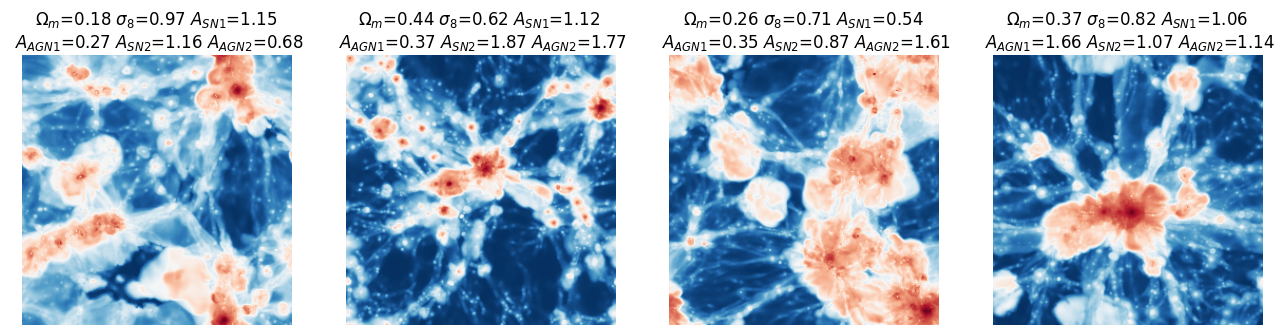

In [42]:
labels = [r'$\Omega_m$', r'$\sigma_8$', r'$A_{SN1}$',
          r'$A_{AGN1}$', r'$A_{SN2}$', r'$A_{AGN2}$']

# plot a few examples of the data
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    ind = np.random.randint(len(x))
    im = axs[i].imshow(x[ind,0], cmap='RdBu_r')

    title = [f'{labels[j]}={theta[ind,j]:.2f}' for j in range(6)]
    title.insert(3, '\n')
    axs[i].set_title(' '.join(title))
    axs[i].axis('off')

In [43]:
# let's build a convolutional embedding network for processing images

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=8, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [44]:
# define a prior
prior = sbi.utils.BoxUniform(low=prior_min, high=prior_max, device=device)

# define an inference class (here, we are doing amortized posterior inference)
inference_class = sbi.inference.SNPE

# instantiate a CNN embedding network
embedding_net = ConvNet()

# instantiate your neural networks to be used as an ensemble
nets = [
    sbi.utils.posterior_nn(model='mdn', embedding_net=embedding_net, hidden_features=16, num_components=1),
    sbi.utils.posterior_nn(model='maf', embedding_net=embedding_net, hidden_features=16, num_transforms=5)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4,
    'stop_after_epochs': 50
}

# initialize the trainer
runner = SBIRunner(
    prior=prior,
    inference_class=inference_class,
    nets=nets,
    device=device,
    embedding_net=embedding_net,
    train_args=train_args,
    proposal=None,
    output_path=None  # no output path, so nothing will be saved to file
)

In [45]:
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: SNPE_C
INFO:root:Training model 1 out of 2 ensemble models


 Neural network successfully converged after 253 epochs.

INFO:root:Training model 2 out of 2 ensemble models


 Neural network successfully converged after 144 epochs.

INFO:root:It took 1241.4781374931335 seconds to train all models.


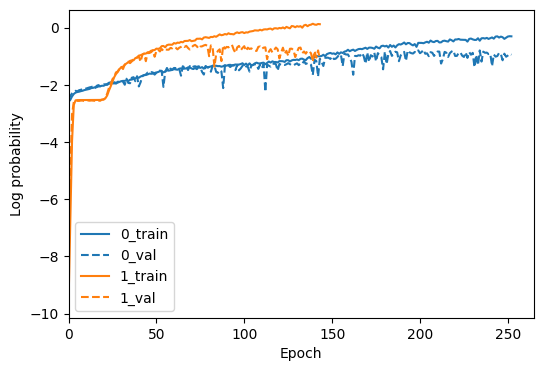

In [46]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [59]:
# choose a random input
ind = np.random.randint(len(theta))
x_test = torch.Tensor(x[ind]).to(device)

# generate samples from the posterior using accept/reject sampling
samples = posterior_ensemble.sample((1000,), x_test)
# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, x_test)

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

Drawing 556 posterior samples:   0%|          | 0/556 [00:00<?, ?it/s]

Drawing 444 posterior samples:   0%|          | 0/444 [00:00<?, ?it/s]

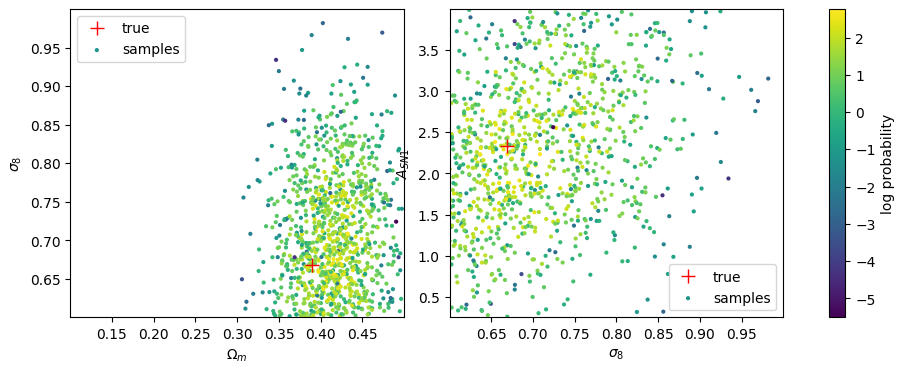

In [60]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_xlim(prior_min[i], prior_max[i])
    axs[i].set_ylim(prior_min[i+1], prior_max[i+1])
    axs[i].set_xlabel(labels[i])
    axs[i].set_ylabel(labels[i+1])
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[2])

Drawing 562 posterior samples:   0%|          | 0/562 [00:00<?, ?it/s]

Drawing 438 posterior samples:   0%|          | 0/438 [00:00<?, ?it/s]

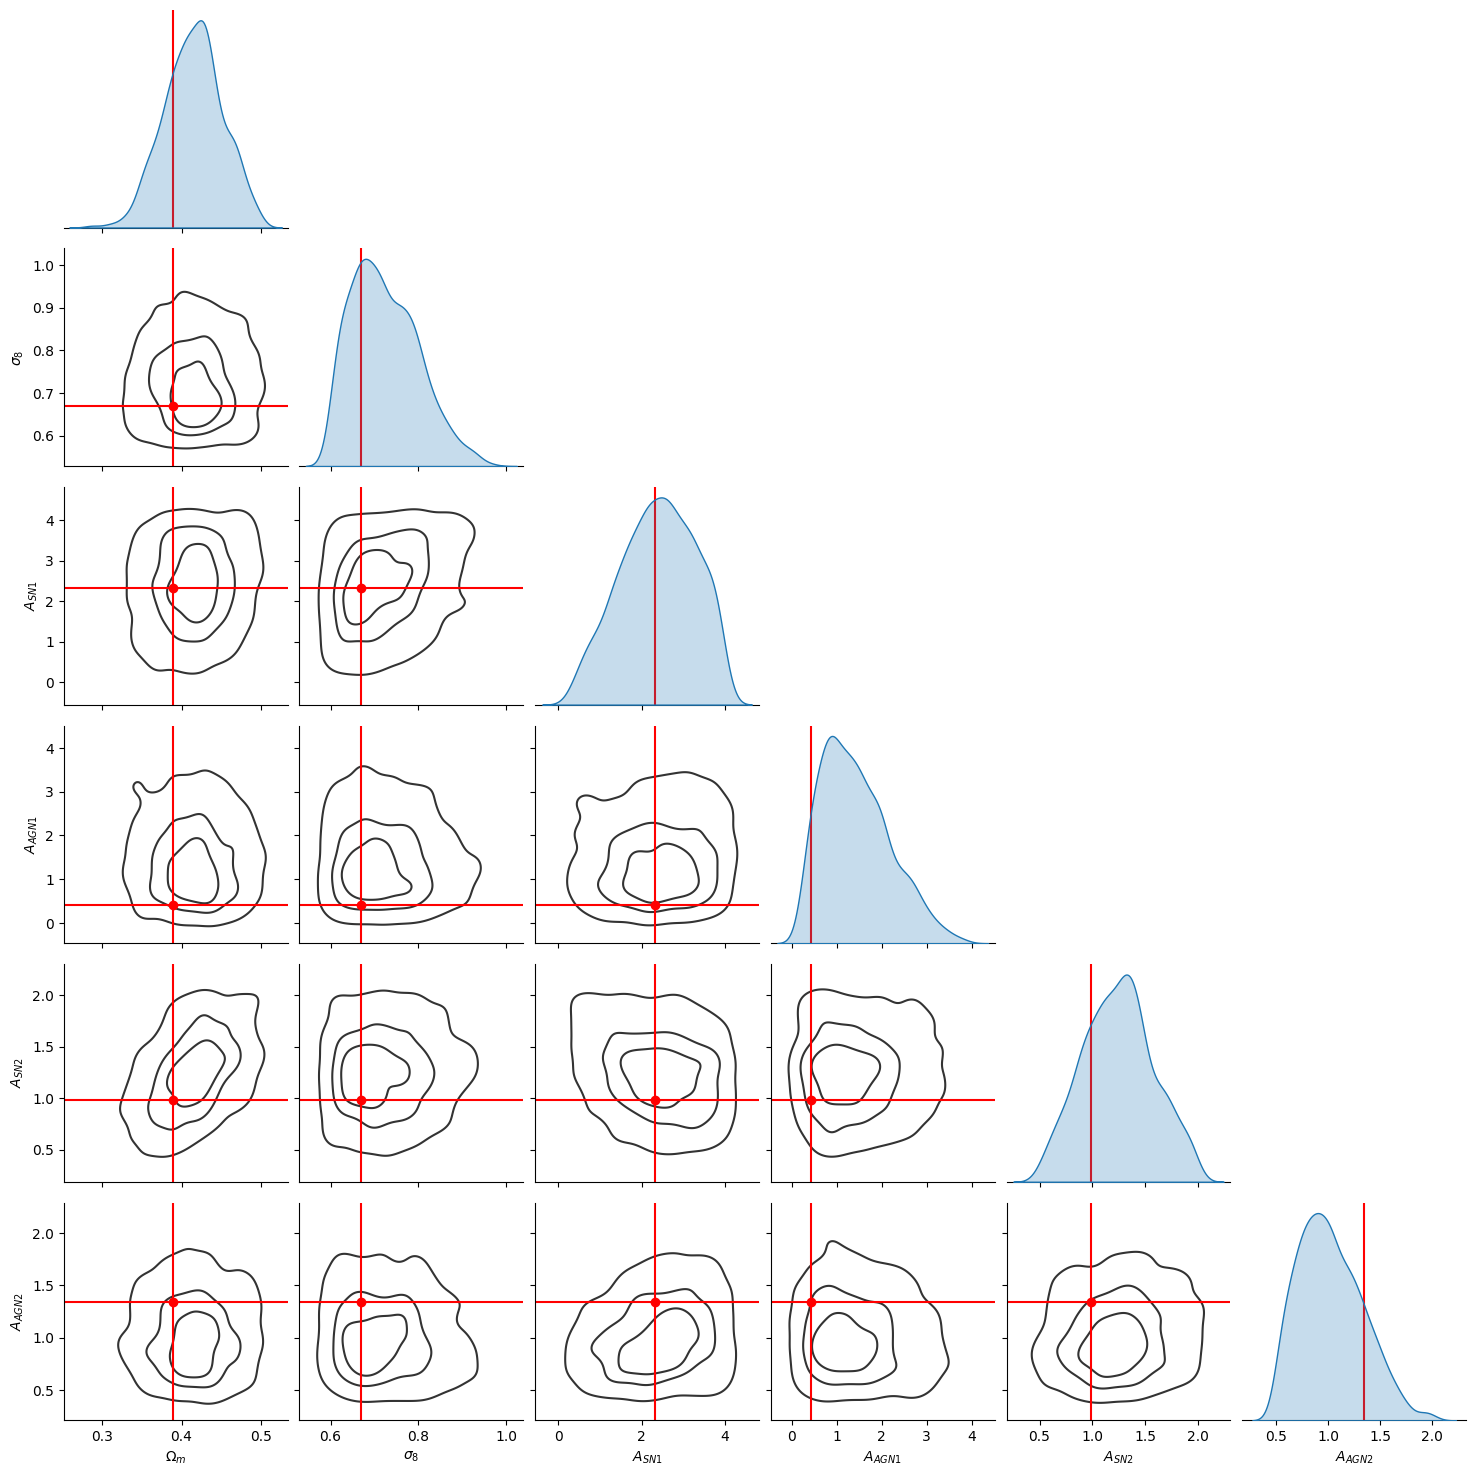

In [61]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='direct', labels=labels
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_obs=theta[ind],
    x=x, theta=theta
)

100%|██████████| 938/938 [00:24<00:00, 38.13it/s]


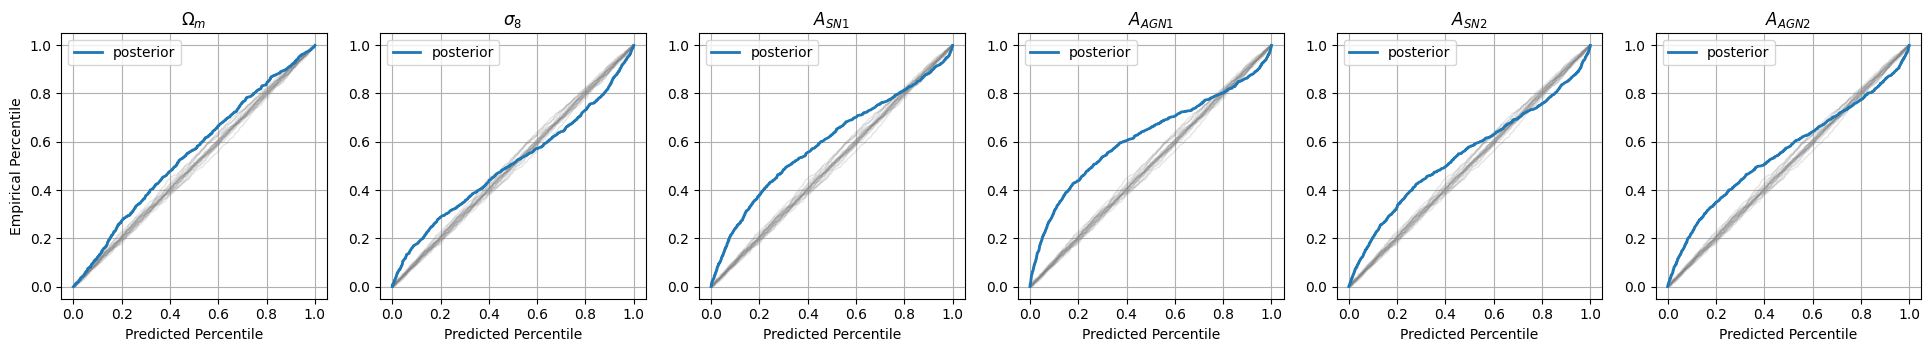

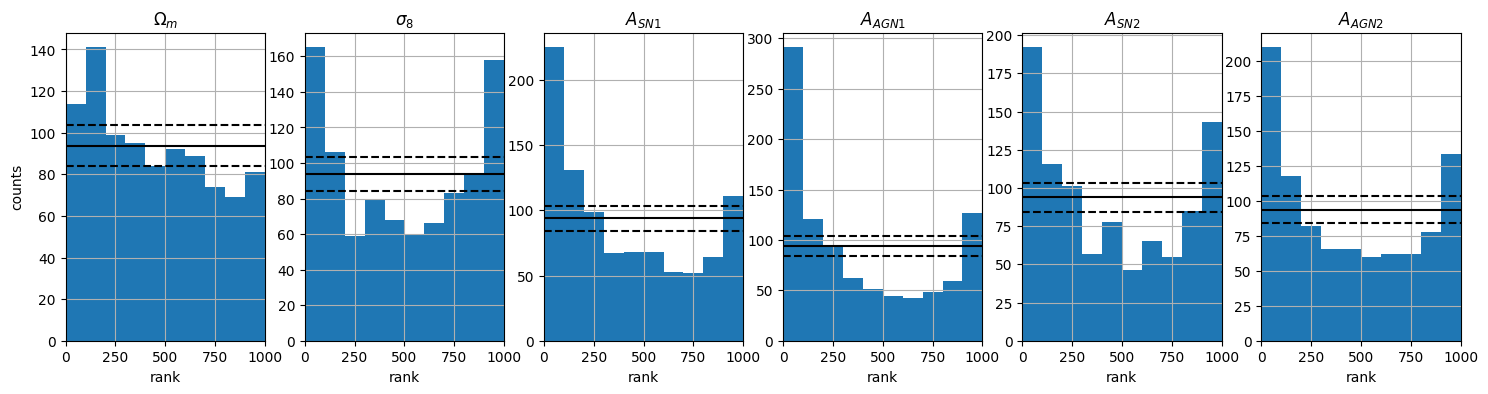

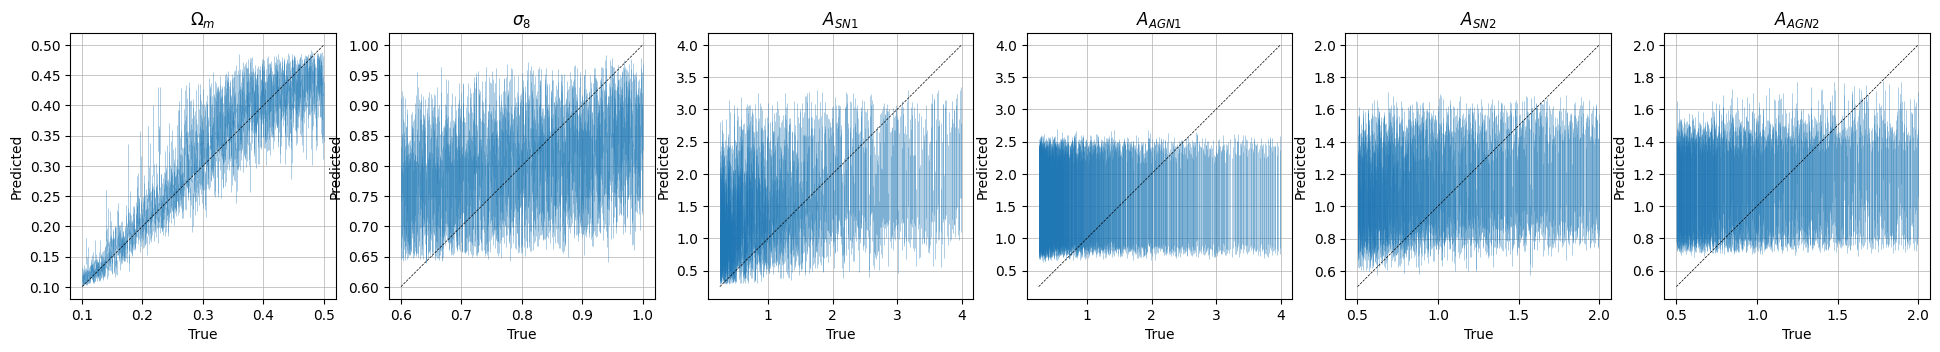

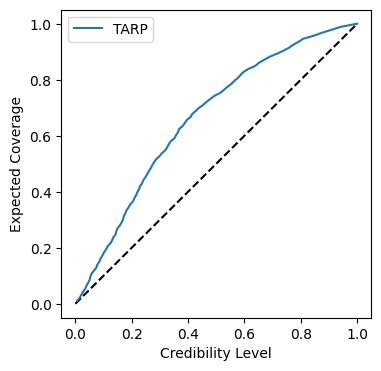

In [63]:
# calculate and plot the rank statistics to describe univariate posterior coverage
metric = PosteriorCoverage(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='direct',
    labels=labels, plot_list = ["coverage", "histogram", "predictions", "tarp"]
)
fig = metric(
    posterior=posterior,
    x=x[::8], theta=theta[::8]
)

As you can see, we are picking up on clear information on $\Omega_m$ and some on $\sigma_8$ and $A_\mathrm{SN1}$, but not much on the other parameters. This mimics the finding of the CAMELS CMD example, albeit with worse constraints (likely since we have not optimized our CNN architecture). We can see that in the parameters which we can constrain well, we are fairly well-calibrated, but on the whole our posteriors are slightly negatively biased. This is likely the result of the limited prior range, which is cutting off the tails of the posterior for the unconstrained variables.

Nonetheless, this demonstrates how the ltu-ili framework can be used to perform inference on real datasets using customizable embedding networks.